In [3]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!pip install keras==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.13.1 which is incompatible.


In [4]:
dir_Flickr_text = "/kaggle/input/flicker8k-text/Flickr8k.token.txt"
train_images_path = '/kaggle/input/flicker8k-text/Flickr_8k.trainImages.txt'
test_images_path = '/kaggle/input/flicker8k-text/Flickr_8k.testImages.txt'
image_path = '/kaggle/input/flickr8k/Images'
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [5]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


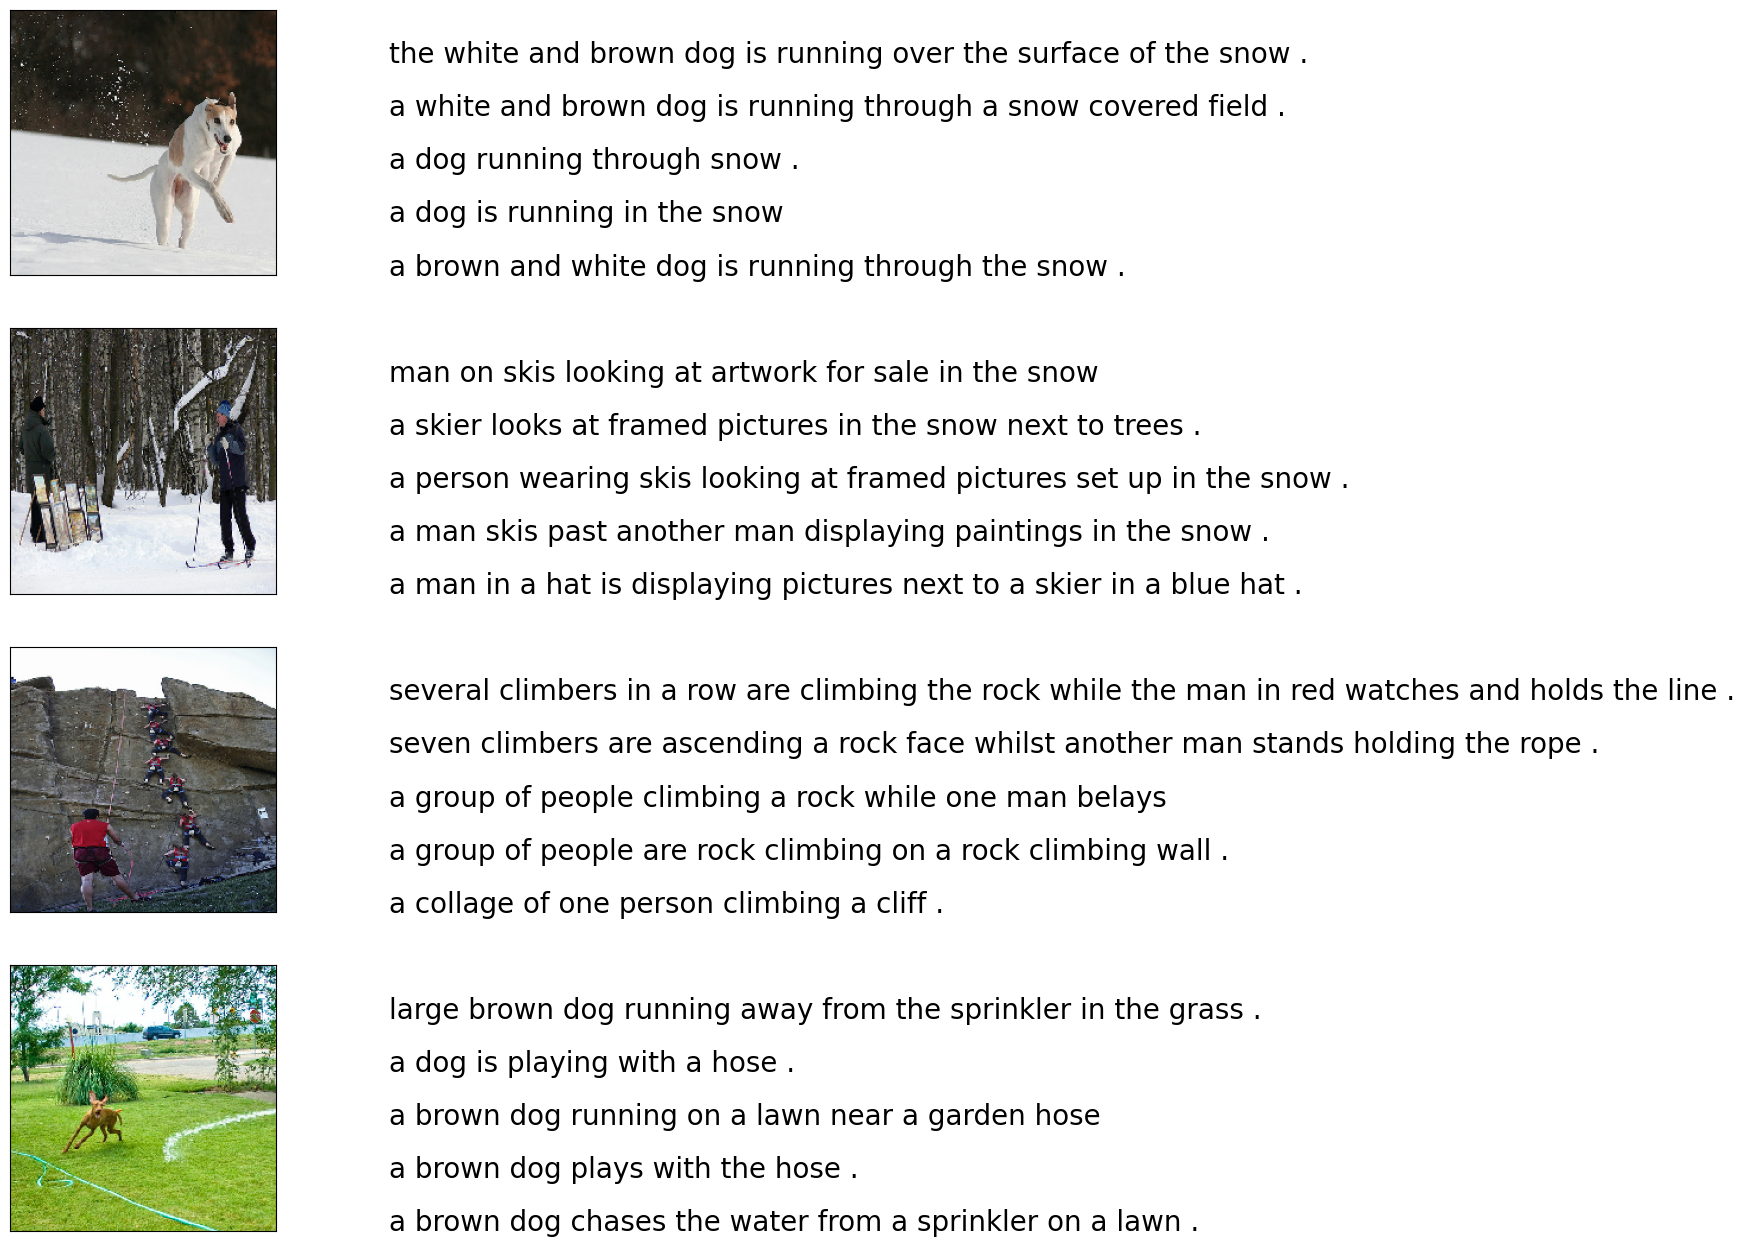

In [6]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [7]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [8]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the ResNet-50 model
resnet_model = resnet50(pretrained=True)
# Remove the fully connected layers
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-2])
# Freeze the parameters
for param in resnet_model.parameters():
    param.requires_grad = False
# Move model to device
resnet_model = resnet_model.to(device)

# Define transformations for input images
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Function to preprocess and extract features for a batch of images
def process_images(image_paths):
    batch_images = []
    for image_path in image_paths:
        image = Image.open(image_path).convert('RGB')
        image = image_transform(image).unsqueeze(0).to(device)
        batch_images.append(image)
    batch_images = torch.cat(batch_images, dim=0)
    with torch.no_grad():
        features = resnet_model(batch_images).squeeze()  # Extract features
    return features

# Batch size for mini-batch processing
batch_size = 64

# Path to directory containing images
image_path = '/kaggle/input/flickr8k/Images/'
jpgs = os.listdir(image_path)

# Take only 4000 images
num_images = 4000
uni_filenames = np.random.choice(jpgs, num_images, replace=False)

# List to store image embeddings
image_embeddings = []

# Process images to extract embeddings
for i in range(0, len(uni_filenames), batch_size):
    batch_filenames = uni_filenames[i:i+batch_size]
    batch_image_paths = [os.path.join(image_path, filename) for filename in batch_filenames]
    batch_embeddings = process_images(batch_image_paths)
    image_embeddings.append(batch_embeddings)

# Concatenate image embeddings from all mini-batches
image_embeddings = torch.cat(image_embeddings, dim=0)

# Convert image embeddings to numpy array
image_embeddings = image_embeddings.cpu().numpy()

# Check the shape of the image embeddings
print("Shape of image embeddings:", image_embeddings.shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s] 


Shape of image embeddings: (4000, 2048, 7, 7)


In [9]:
import pickle

# Specify the file path for saving the pickle file
output_pkl_file = '/kaggle/working/image_embeddings.pkl'

# Save the image embeddings to a pickle file
with open(output_pkl_file, 'wb') as f:
    pickle.dump(image_embeddings, f)

print("Image embeddings saved to", output_pkl_file)

Image embeddings saved to /kaggle/working/image_embeddings.pkl


In [10]:
!wget  'https://nlp.stanford.edu/data/glove.42B.300d.zip'

--2024-04-22 01:15:27--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2024-04-22 01:15:27--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: 'glove.42B.300d.zip'

glove.42B.300d.zip  100%[===================>]   1.75G  4.99MB/s    in 5m 52s  

2024-04-22 01:21:20 (5.09 MB/s) - 'glove.42B.300d.zip' saved [1877800501/1877800501]



In [11]:
# Specify the path to the zip file
zip_file_path = "/kaggle/working/glove.42B.300d.zip"

# Specify the directory where you want to extract the contents
extract_to_directory = " /kaggle/working/glove"

# Create the directory if it doesn't exist
import os
os.makedirs(extract_to_directory, exist_ok=True)

# Use the !unzip command to extract the contents of the zip file to the specified directory
!unzip -q {zip_file_path} -d {extract_to_directory}

print("Extraction complete.")

Extraction complete.


In [26]:
!pip install keras

In [12]:
import os
import numpy as np
#import tensorflow.keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from PIL import Image
import matplotlib.pyplot as plt
import pickle

# Function to generate captions for images
def generate_captions(image_dir, captions_file):
    captions = {}
    with open(captions_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            image_id, caption = parts[0], parts[1]
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

# Load GloVe pre-trained model
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    embeddings_index = {}
    with open(gloveFile, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print("Done.", len(embeddings_index), " words loaded!")
    return embeddings_index

# Tokenize captions
def Cap_tokenize(captions):
    print("Tokenizing Captions")
    tokenizer = Tokenizer(num_words=4500, oov_token="<unk>")
    tokenizer.fit_on_texts(captions)
    tokenized_captions = tokenizer.texts_to_sequences(captions)
    print("Done.")
    return tokenizer, tokenized_captions

# Convert text to sequences
def Text2seq(tokenizer, tokenized_captions):
    print("Converting Text to Sequences")
    vocab_size = len(tokenizer.word_index) + 1
    max_length = 30
    padded_captions = pad_sequences(tokenized_captions, maxlen=max_length, padding='post')

    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print("Done.")
    return vocab_size, embedding_matrix, padded_captions

# Load GloVe pre-trained model
gloveFile = "/kaggle/working/glove/glove.42B.300d.txt"
embeddings_index = loadGloveModel(gloveFile)

# Directory containing images
image_dir = "/kaggle/input/flickr8k/Images"

# File containing captions
captions_file = "/kaggle/input/flicker8k-text/Flickr8k.token.txt"

# Generate captions for images
captions = generate_captions(image_dir, captions_file)

# Extract captions from the dictionary
all_captions = [caption for captions_list in captions.values() for caption in captions_list]

# Tokenize captions
tokenizer, tokenized_captions = Cap_tokenize(all_captions)

# Convert text to sequences
vocab_size, embedding_matrix, padded_captions = Text2seq(tokenizer, tokenized_captions)

# Save tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



Loading Glove Model
Done. 1917494  words loaded!
Tokenizing Captions
Done.
Converting Text to Sequences
Done.


In [13]:
import tensorflow as tf
from keras import layers, models

# Model for image encoder
def image_encoder(input_shape):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu')
    ])
    return model

# Model for text encoder
def text_encoder(vocab_size, embedding_dim):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        layers.LSTM(512)
    ])
    return model

# Siamese network
def siamese_net(image_shape, vocab_size, embedding_dim):
    # Image encoder
    image_input = layers.Input(shape=image_shape)
    image_enc = image_encoder(image_shape)(image_input)

    # Text encoder
    text_input = layers.Input(shape=(None,))
    text_enc = text_encoder(vocab_size, embedding_dim)(text_input)

    # Combined model
    merged_vector = layers.Concatenate()([image_enc, text_enc])
    output = layers.Dense(1, activation='sigmoid')(merged_vector)

    model = models.Model(inputs=[image_input, text_input], outputs=output)
    return model

# Example usage
image_shape = (224, 224, 3)  # Example image shape
vocab_size = 10000  # Example vocabulary size
embedding_dim = 300  # Example embedding dimension

model = siamese_net(image_shape, vocab_size, embedding_dim)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 512)       │ 39,300,224 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 512)       │  4,665,024 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      1,025 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,966,273 (167.72 MB)

 Trainable params: 43,966,273 (167.72 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import tensorflow as tf

# Triplet batch creation (Easy triplets)
def create_triplet_batch(anchors, positives, negatives, batch_size):
    num_samples = len(anchors)
    indices = tf.range(num_samples)

    anchor_indices = tf.random.shuffle(indices)[:batch_size]
    positive_indices = tf.random.shuffle(indices)[:batch_size]
    negative_indices = tf.random.shuffle(indices)[:batch_size]

    anchor_batch = tf.gather(anchors, anchor_indices)
    positive_batch = tf.gather(positives, positive_indices)
    negative_batch = tf.gather(negatives, negative_indices)

    return anchor_batch, positive_batch, negative_batch

# Triplet loss function
def triplet_loss(anchor_embedding, positive_embedding, negative_embedding, margin=1.0):
    anchor_positive_dist = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=-1)
    anchor_negative_dist = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=-1)

    loss = tf.maximum(anchor_positive_dist - anchor_negative_dist + margin, 0.0)
    return loss

anchor_embeddings = tf.random.normal(shape=(100, 256))  # Example anchor image embeddings
positive_embeddings = tf.random.normal(shape=(100, 256))  # Example positive caption embeddings
negative_embeddings = tf.random.normal(shape=(100, 256))  # Example negative caption embeddings
batch_size = 32  # Batch size for triplet creation

# Triplet batch creation
anchor_batch, positive_batch, negative_batch = create_triplet_batch(anchor_embeddings, positive_embeddings, negative_embeddings, batch_size)

# Calculate triplet loss
loss = triplet_loss(anchor_batch, positive_batch, negative_batch)
print(loss)

tf.Tensor(
[ 0.       76.48932  12.132843  0.        0.        0.        0.
 90.523895 56.325134  0.       52.548584 11.847046  0.        6.378357
 52.04712  16.741516 49.105103  0.       41.10132   0.        9.872406
 24.990784  0.        0.       82.17413  32.3537   65.58032   0.
  0.       52.79373   0.       35.08618 ], shape=(32,), dtype=float32)


In [24]:
import tensorflow as tf
from keras import layers, models
import numpy as np
import pickle

# Define siamese network with image and text inputs
def siamese_net(image_shape, vocab_size, embedding_dim, max_seq_length):
    # Image input
    image_input = layers.Input(shape=image_shape, name="image_input")
    
    # Text input
    text_input = layers.Input(shape=(max_seq_length,), name="text_input")
    
    # Image encoder
    image_enc = layers.Flatten()(image_input)  # Flattening the image input
    image_enc = layers.Dense(512, activation='relu', name="image_encoder")(image_enc)
    
    # Text encoder
    text_enc = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length, name="text_encoder")(text_input)
    text_enc = layers.LSTM(512)(text_enc)
    
    # Concatenate image and text encodings
    merged_vector = layers.Concatenate()([image_enc, text_enc])
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid', name="output")(merged_vector)
    
    # Create model
    model = models.Model(inputs=[image_input, text_input], outputs=output)
    return model

# Load image embeddings from pickle file
with open("image_embeddings.pkl", "rb") as f:
    image_embeddings = pickle.load(f)

# Load tokenizer from pickle file
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load captions from file
with open("/kaggle/input/flicker8k-text/Flickr8k.token.txt", "r") as f:
    captions_data = f.readlines()

# Extract image paths and captions from the captions data
train_image_paths = []
train_captions = []
for line in captions_data:
    parts = line.strip().split("\t")
    image_path, caption = parts[0].split("#")[0], parts[1]
    train_image_paths.append(image_path)
    train_captions.append(caption)

# Assuming you have train images path in a variable named train_images_path
# Load train image paths from file
train_image_paths = []
with open("/kaggle/input/flicker8k-text/Flickr_8k.trainImages.txt", "r") as f:
    for line in f:
        train_image_paths.append(line.strip())

# Assuming you have train captions in a variable named train_captions
# You should replace it with your actual train captions data
# Convert captions to sequences of tokens using the tokenizer
train_sequences = tokenizer.texts_to_sequences(train_captions)

# Pad sequences to ensure uniform length
max_seq_length = 30  # Example maximum sequence length
train_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_seq_length)

# Define parameters
image_shape = image_embeddings.shape[1:]
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300  # Assuming you used this dimension when training the tokenizer

# Create Siamese network model
model = siamese_net(image_shape, vocab_size, embedding_dim, max_seq_length)
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Check the number of samples in each dataset
num_image_embeddings = len(image_embeddings)
num_captions = len(train_captions_padded)

# If the number of samples in image_embeddings is greater than train_captions_padded,
# filter out the excess image embeddings
if num_image_embeddings > num_captions:
    image_embeddings = image_embeddings[:num_captions]

# If the number of samples in train_captions_padded is greater than image_embeddings,
# filter out the excess captions
elif num_captions > num_image_embeddings:
    train_captions_padded = train_captions_padded[:num_image_embeddings]

# Now both datasets have the same number of samples
# You can proceed with training
history = model.fit(
    x={"image_input": image_embeddings, "text_input": train_captions_padded},
    y=np.zeros(num_image_embeddings),  # Placeholder for labels, not used
    batch_size=32,
    epochs=10
)

# Save the trained model
model.save("siamese_network_trained_model.h5")


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048, 7,   │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 100352)    │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_encoder        │ (None, 30, 300)   │  2,548,500 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_encoder       │ (None, 512)       │ 51,380,736 │ flatten_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 512)       │  1,665,024 │ text_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1024)      │          0 │ image_encoder[0]… │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │      1,025 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,595,285 (212.08 MB)

 Trainable params: 55,595,285 (212.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9852 - loss: 0.0268
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [53]:
from keras.models import load_model

# Load the Siamese network model
siamese_model = load_model("siamese_network_trained_model.h5")

# Print the model summary to see the input shape
siamese_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048, 7,   │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 100352)    │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_encoder        │ (None, 30, 300)   │  2,548,500 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_encoder       │ (None, 512)       │ 51,380,736 │ flatten_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 512)       │  1,665,024 │ text_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1024)      │          0 │ image_encoder[0]… │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │      1,025 │ concatenate_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,595,287 (212.08 MB)

 Trainable params: 55,595,285 (212.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [81]:
import numpy as np
from keras.models import load_model

# Load the trained Siamese network model
siamese_model = load_model("siamese_network_trained_model.h5")

def user_input_text_embed(user_input_text, tokenizer, max_seq_length):
    # Tokenize the user input text
    user_input_sequence = tokenizer.texts_to_sequences([user_input_text])
    
    # Pad the sequence to match the maximum sequence length
    user_input_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(user_input_sequence, maxlen=max_seq_length)
    
    # Predict text embedding using the siamese model
    text_embedding = siamese_model.get_layer("text_encoder")(user_input_sequence_padded)

    # Ensure the text embedding has the expected shape (typically a 2D array)
    text_embedding = np.asarray(text_embedding)

    return text_embedding

def cosine_similarity(embedding1, embedding2):
    # Reshape embeddings to be 2D arrays
    embedding1_reshaped = embedding1.flatten()
    embedding2_reshaped = embedding2.flatten()
    
    # Calculate dot product and norms
    dot_product = np.dot(embedding1_reshaped, embedding2_reshaped)
    norm1 = np.linalg.norm(embedding1_reshaped)
    norm2 = np.linalg.norm(embedding2_reshaped)
    
    # Calculate cosine similarity
    similarity = dot_product / (norm1 * norm2)
    return similarity

def find_k_nearest_images(text_embedding, image_embeddings, k=10):
    similarities = []
    for image_embedding in image_embeddings:
        similarity = cosine_similarity(text_embedding, image_embedding)
        similarities.append(similarity)
    similarities = np.array(similarities)
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return top_k_indices

def plot_top_k_images(top_k_indices, image_paths):
    import matplotlib.pyplot as plt
    from PIL import Image
    
    # Plot top K images in a grid
    num_cols = 5
    num_rows = (len(top_k_indices) - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(top_k_indices):
            image_path = image_paths[top_k_indices[i]]
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Image {i+1}")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [91]:
import numpy as np
from keras.models import load_model

# Load the trained Siamese network model
siamese_model = load_model("siamese_network_trained_model.h5")

# Define function to convert user input text to tokenized integer sequence and predict its text embedding
def user_input_text_embed(user_input_text, tokenizer, max_seq_length):
    # Tokenize the user input text
    user_input_sequence = tokenizer.texts_to_sequences([user_input_text])
    
    # Pad the sequence to match the maximum sequence length
    user_input_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(user_input_sequence, maxlen=max_seq_length)
    
    # Create a placeholder image input (can be zeros or any other placeholder value)
    placeholder_image_input = np.zeros((1, image_shape[0], image_shape[1], image_shape[2]))  # Assuming image_shape is defined
    
    # Predict text embedding using the siamese model
    text_embedding = siamese_model.predict({"image_input": placeholder_image_input, "text_input": user_input_sequence_padded})
    
    return text_embedding

# Function to find k nearest images based on Euclidean distance
def find_k_nearest_images(text_embedding, image_embeddings, k=10):
    distances = np.linalg.norm(image_embeddings - text_embedding.flatten(), axis=1)
    top_k_indices = np.argsort(distances)[:k]
    return top_k_indices.astype(int)  # Convert indices to integers


def plot_top_k_images(top_k_indices, image_paths):
    import matplotlib.pyplot as plt
    from PIL import Image
    
    # Plot top K images in a grid
    num_cols = 5
    num_rows = (len(top_k_indices) - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(top_k_indices):
            image_path = image_paths[top_k_indices[i]]  # Assuming image_paths is a list of image paths
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Image {i+1}")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    
print("top_k_indices:", top_k_indices)
print("image_paths:", image_paths)




top_k_indices: [[[4 3 2 5 1 6 0]
  [1 0 2 3 4 5 6]
  [0 2 1 3 4 6 5]
  [0 1 2 3 4 6 5]
  [0 1 2 3 4 6 5]
  [0 1 4 6 5 2 3]
  [0 1 4 5 6 3 2]]

 [[2 4 3 1 5 0 6]
  [0 2 3 1 4 5 6]
  [0 1 2 6 5 3 4]
  [0 1 2 6 3 5 4]
  [0 1 2 6 3 5 4]
  [2 0 1 6 3 5 4]
  [3 2 4 6 5 1 0]]

 [[2 3 4 1 5 0 6]
  [3 4 2 0 5 6 1]
  [6 0 3 4 5 2 1]
  [6 0 5 1 2 4 3]
  [6 0 5 1 3 2 4]
  [6 0 5 1 3 2 4]
  [5 6 4 3 0 1 2]]

 [[3 2 4 0 1 5 6]
  [0 1 6 2 5 3 4]
  [0 6 1 5 2 3 4]
  [6 0 1 5 2 4 3]
  [6 0 5 1 4 2 3]
  [6 5 4 0 3 2 1]
  [5 4 3 6 2 0 1]]

 [[0 1 6 5 2 4 3]
  [0 1 6 5 2 4 3]
  [0 1 6 5 4 3 2]
  [0 6 1 5 4 3 2]
  [0 5 6 1 4 2 3]
  [0 1 4 5 2 3 6]
  [0 3 2 4 1 5 6]]

 [[0 4 3 2 1 5 6]
  [0 1 4 5 6 3 2]
  [0 6 5 1 4 3 2]
  [6 0 5 4 1 3 2]
  [6 5 0 4 3 1 2]
  [5 4 0 6 3 1 2]
  [4 5 0 6 3 1 2]]

 [[2 1 0 3 4 6 5]
  [1 2 0 3 4 5 6]
  [0 2 3 1 4 5 6]
  [0 2 1 3 4 5 6]
  [0 6 5 1 4 2 3]
  [0 6 5 1 4 2 3]
  [0 6 5 1 4 2 3]]

 [[4 1 0 3 2 5 6]
  [0 1 2 3 5 6 4]
  [0 1 2 6 4 3 5]
  [0 1 2 6 5 3 4]
  [0 1 2 6 3 5 4]

NameError: name 'image_paths' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


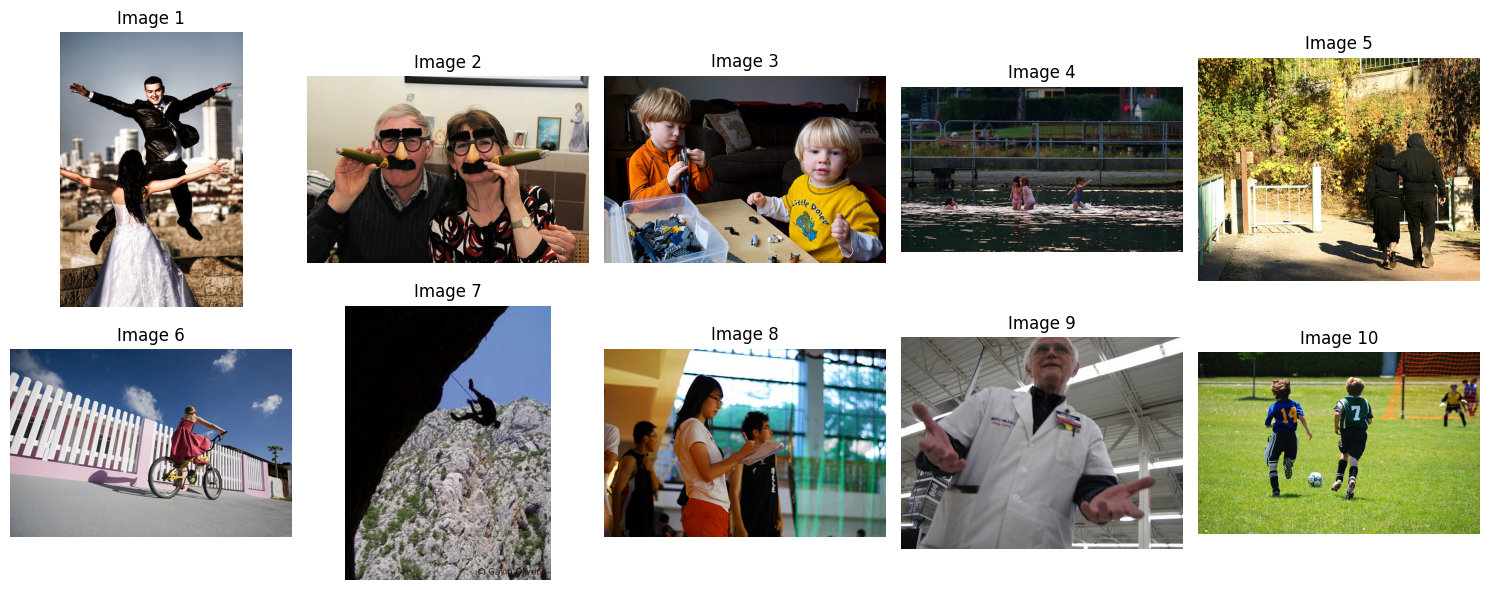

In [97]:
import numpy as np
import os
from keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances

# Load the trained Siamese network model
siamese_model = load_model("siamese_network_trained_model.h5")

# Directory containing all the images
image_dir = "/kaggle/input/flickr8k/Images"

# List all files in the directory
image_files = os.listdir(image_dir)

# Construct full paths to the images
image_paths = [os.path.join(image_dir, filename) for filename in image_files]

# Define function to convert user input text to tokenized integer sequence and predict its text embedding
def user_input_text_embed(user_input_text, tokenizer, max_seq_length):
    # Tokenize the user input text
    user_input_sequence = tokenizer.texts_to_sequences([user_input_text])
    
    # Pad the sequence to match the maximum sequence length
    user_input_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(user_input_sequence, maxlen=max_seq_length)
    
    # Create a placeholder image input (can be zeros or any other placeholder value)
    placeholder_image_input = np.zeros((1, image_shape[0], image_shape[1], image_shape[2]))  # Assuming image_shape is defined
    
    # Predict text embedding using the siamese model
    text_embedding = siamese_model.predict({"image_input": placeholder_image_input, "text_input": user_input_sequence_padded})
    
    return text_embedding

def find_k_nearest_images(text_embedding, image_embeddings, k=10):
    # Reshape image_embeddings to have the same number of features as text_embedding
    image_embeddings_reshaped = image_embeddings.reshape(image_embeddings.shape[0], -1)
    
    # Repeat the text_embedding along the first axis to match the number of images
    text_embedding_reshaped = np.repeat(text_embedding, image_embeddings_reshaped.shape[0], axis=0)
    
    # Calculate Euclidean distances between text embedding and each image embedding
    distances = np.linalg.norm(image_embeddings_reshaped - text_embedding_reshaped, axis=1)
    
    # Get indices of top k nearest images based on Euclidean distance
    top_k_indices = np.argsort(distances)[:k]
    
    return top_k_indices.astype(int)

def plot_top_k_images(top_k_indices, image_paths):
    # Plot top K images in a grid
    num_cols = 5
    num_rows = (len(top_k_indices) - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    for i, ax in enumerate(axes.flat):
        if i < len(top_k_indices):
            image_path = image_paths[top_k_indices[i]]  # Assuming image_paths is a list of image paths
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(f"Image {i+1}")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
user_input_text = "Dog"
text_embedding = user_input_text_embed(user_input_text, tokenizer, max_seq_length)
top_k_indices = find_k_nearest_images(text_embedding, image_embeddings)
plot_top_k_images(top_k_indices, image_paths)
